# Welcome to Learning about Fine Tuning a LLM

### Task 1 - Set up the project environment

In [1]:
!pip install openai==1.7.2 python-dotenv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.1/212.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.5 MB/s eta 0:00:00


Importing modules

In [3]:
import pandas as pd
import os, time
from openai import OpenAI
from dotenv import load_dotenv
import json
import matplotlib.pyplot as plt

print("Modules are imported.")

Modules are imported.


Setting up the OpenAI API:

* Prepare a .env file to store the OpenAI API key.
* Uploading the .env file to our colab environment
* Load the API key and setup the API

Creating OpenAI Client

In [4]:
load_dotenv("apikey.env.txt")
APIKEY = os.getenv("APIKEY")
client = OpenAI(api_key=APIKEY)

### Task 2 - Prepare the training data

Loading the provided `Customer Complaints.csv`



In [5]:
training_data = pd.read_csv("Customer Complaints.csv")
training_data

,Complaints,Details
0,Unreliable internet! Sick of constant outages...,"{""Topic"": ""Internet"", ""Problem"": ""Unreliable s..."
1,TV signal keeps dropping during crucial momen...,"{""Topic"": ""TV"", ""Problem"": ""Signal dropout"", ""..."
2,Phone line always crackling! Can't hear a thi...,"{""Topic"": ""Phone"", ""Problem"": ""Crackling line""..."
3,Ridiculous prices for such terrible service! ...,"{""Topic"": ""Billing"", ""Problem"": ""Overcharged"",..."
4,Internet speed slower than a snail! Can't str...,"{""Topic"": ""Internet"", ""Problem"": ""Slow speed"",..."
...,...,...
62,Poor call quality during international calls! ...,"{""Topic"": ""Phone"", ""Problem"": ""Poor call quali..."
63,Incorrect charges on my bill every month! Unre...,"{""Topic"": ""Billing"", ""Problem"": ""Incorrect cha..."
64,This service is terrible! Can't believe I'm pa...,"{""Topic"": ""PulseNet General"", ""Problem"": ""Gene..."
65,This product is a complete waste of money! Dis...,"{""Topic"": ""PulseNet General"", ""Problem"": ""Gene..."


**Converting the Complaints records to json**

To be able to use the data for the fine-tuning purpose, we first need to convert each row of the dataframe into the following format:

<pre>
<code>
{
  <span style="color: blue;">"messages"</span>: [
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"system"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">Providing context about the user's prompt.
                  It may include information about the task,
                  instructions, or background details relevant
                  to the conversation.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"user"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">the prompt or input provided by the user,
                  which typically initiates the conversation with the assistant.</span>"
    },
    {
      <span style="color: blue;">"role"</span>: <span style="color: red;">"assistant"</span>,
      <span style="color: blue;">"content"</span>: "<span style="color: green;">The desired response or output generated by
                  the assistant in response to the user's prompt.</span>"
    }
  ]
}
</code>
</pre>

Let's get started!

Let's define a method that get's a row of the dataframe and convert it into the json format

In [6]:
def save_as_json(row):

  system_content = """
      Given a customer complaint text, extract and return the following information in json (dict) format:
      - Topic: The product/department that the customer has a complaint about.
      - Problem: A two or three-word description of what exactly the problem is.
      - Customer_Dissatisfaction_Index: is a number between 0 and 100 showing
             how angry the customer is about the problem.
  """

  formatted_data = {
        "messages": [
            {"role": "system", "content": system_content},
            {"role": "user", "content": row.Complaints},
            {"role": "assistant", "content": row.Details}
        ]
      }

  with open("training_data.json", "a") as json_file:
        json.dump(formatted_data, json_file)
        json_file.write("\n")

Now let's use of this method to generate the `training_data.json`

In [7]:
for index, row in training_data.iterrows():
  save_as_json(row)

### Task 3 - Fine-tune GPT 3.5 based on our training data

Let's import the json file we prepared as our training data

In [8]:
data_file = client.files.create(
    file = open(r"training_data.json", "rb"),
    purpose = "fine-tune"
)
data_file

FileObject(id='file-L9AL1NNcRDaOjKc0fPJpvoOH', bytes=46722, created_at=1719158544, filename='training_data.json', object='file', purpose='fine-tune', status='processed', status_details=None)

Create the Fine Tuning Job

In [9]:
fine_tuning_job = client.fine_tuning.jobs.create(
    training_file = data_file.id,
    model = "gpt-3.5-turbo",
    hyperparameters={
        "n_epochs": 1
    }
)
fine_tuning_job

FineTuningJob(id='ftjob-vkALK0VbEe1iLlBt4kgxs6sw', created_at=1719158562, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-g3gtjfvCxGWSAcqG4QfXdvkR', result_files=[], status='validating_files', trained_tokens=None, training_file='file-L9AL1NNcRDaOjKc0fPJpvoOH', validation_file=None, user_provided_suffix=None, seed=95727310, estimated_finish=None, integrations=[])

Let's retrieve the state of the fine-tune

In [15]:
retrieved_job = client.fine_tuning.jobs.retrieve(fine_tuning_job.id)
status = retrieved_job.status
print(status)

succeeded


### Task 4 - Evaluate model

Let's retrieve the event messages to check out the learning process of our fine-tuning job.

In [18]:
events = list(client.fine_tuning.jobs.list_events(fine_tuning_job_id = retrieved_job.id, limit = 100).data)
for e in events:
  print(e.message)

The job has successfully completed
New fine-tuned model created: ft:gpt-3.5-turbo-0125:personal::9dK2lRs2
Step 67/67: training loss=0.06
Step 66/67: training loss=0.16
Step 65/67: training loss=0.34
Step 64/67: training loss=0.21
Step 63/67: training loss=0.09
Step 62/67: training loss=0.04
Step 61/67: training loss=0.11
Step 60/67: training loss=0.13
Step 59/67: training loss=0.04
Step 58/67: training loss=0.24
Step 57/67: training loss=0.06
Step 56/67: training loss=0.06
Step 55/67: training loss=0.36
Step 54/67: training loss=0.13
Step 53/67: training loss=0.08
Step 52/67: training loss=0.11
Step 51/67: training loss=0.10
Step 50/67: training loss=0.27
Step 49/67: training loss=0.08
Step 48/67: training loss=0.44
Step 47/67: training loss=0.14
Step 46/67: training loss=0.47
Step 45/67: training loss=0.10
Step 44/67: training loss=0.28
Step 43/67: training loss=0.11
Step 42/67: training loss=0.12
Step 41/67: training loss=0.14
Step 40/67: training loss=0.14
Step 39/67: training loss=

Let's extract the training loss in each learning step

In [20]:
steps = []
train_loss = []
for e in events:
  if(e.data):
    steps.append(e.data['step'])
    train_loss.append(e.data['train_loss'])

print(steps)
print(train_loss)

[67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
[0.05646423250436783, 0.16098327934741974, 0.34059783816337585, 0.2062920480966568, 0.09214115142822266, 0.04494835063815117, 0.11103922873735428, 0.13017067313194275, 0.042802415788173676, 0.23677748441696167, 0.0636114701628685, 0.06017211824655533, 0.3607107698917389, 0.12548235058784485, 0.07770530879497528, 0.1063007190823555, 0.09740391373634338, 0.27242806553840637, 0.08367606997489929, 0.44492295384407043, 0.13785609602928162, 0.4704936742782593, 0.10362695157527924, 0.2804841697216034, 0.11047900468111038, 0.11603428423404694, 0.14097347855567932, 0.13997627794742584, 0.10319871455430984, 0.6467949151992798, 0.13194304704666138, 0.8850393891334534, 0.09301651269197464, 1.0066776275634766, 0.1682167798280716, 0.21822899580

Use a line chart to visualize the train_loss in each step

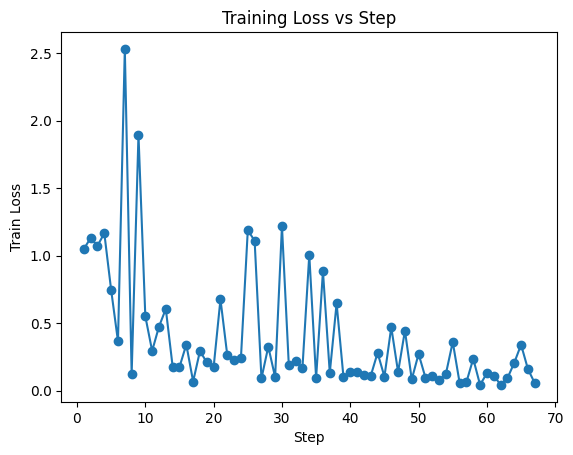

In [22]:
plt.plot(steps, train_loss, marker= 'o', linestyle='-')
plt.xlabel('Step')
plt.ylabel('Train Loss')
plt.title('Training Loss vs Step')
plt.show()

### Task 5 - Deploy our model

Let's take a look at `retrieved_job` again

In [25]:
myLLM = retrieved_job.fine_tuned_model
print(myLLM)

ft:gpt-3.5-turbo-0125:personal::9dK2lRs2


Defining a method to extract information from a given user complaint using a specific LLM and return the results.

In [23]:
def extract_details(user_complaint, model_name):
    """
    This function extracts information from a given user complaint using a specific LLM (Large Language Model).

    Parameters:
    user_complaint (str): The text of the user's complaint.
    model_name (str): The name of the specific LLM model to use for extraction.
    """

    system_content = """
        Given a customer complaint text, extract and return the following information in JSON (dict) format:
        - Topic
        - Problem
        - Customer_Dissatisfaction_Index
    """

    # Generate a response using the specified model and the user's complaint
    response = client.chat.completions.create(
        model = model_name,
        messages=[
            {"role": "system", "content": system_content},  # System content explaining the expected output
            {"role": "user", "content": user_complaint}  # User's complaint passed as content
        ]
    )

    # Return the content of the generated response
    return response.choices[0].message.content


Let's use our fine-tuned model to extract the details for the following user complaint:

*TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!*

In [26]:
complaint = "TV channels keep disappearing from my subscription! What's going on? Extremely annoyed with this service!"
extract_details(complaint, myLLM)

'{"Topic": "TV", "Problem": "Channels disappearing", "Customer_Dissatisfaction_Index": "High"}'

Let's test our `GPT-4` model with the same user complaint

In [27]:
extract_details(complaint, "gpt-4")

'{\n  "Topic": "TV Subscription",\n  "Problem": "Channels disappearing from subscription",\n  "Customer_Dissatisfaction_Index": "High"\n}'

Let's try for the following complaint:

*Line is down! It is really annoying!*

In [29]:
extract_details("Line is down! It is really annoying!", myLLM)

'{"Topic": "Network/Connectivity", "Problem": "Line down", "Customer_Dissatisfaction_Index": 5}'

Now let's compare the results from GPT-4

In [30]:
extract_details("Line is down! It is really annoying!", "gpt-4")

'{\n  "Topic": "Line Issues",\n  "Problem": "Line is down",\n  "Customer_Dissatisfaction_Index": "High"\n}'

We can see that our model, which is trained on our dataset, provides better answers compared to GPT-4. Our model is fine-tuned based on our data and is familiar with the different edge cases and the context of our dataset.

In [31]:
customer_complaint = "I am very Angry! I want my money back!"
extract_details(customer_complaint, myLLM)

'{"Topic": "Billing", "Problem": "Refund delay", "Customer_Dissatisfaction_Index": 10}'